Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [21]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
print("Assignment 1 is started.")

Assignment 1 is started.


First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [22]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [23]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [24]:
ims=[]
n=0
afolder=test_folders[5]
print("Showing pictures in %s" % afolder)
if afolder == '':
    exit
try:
    dirlist = os.listdir(afolder)
except Exception as e:
    print('Unable to list dir', afolder, ':', e)
    
for img_fn in dirlist:
    format = img_fn.split('.')[-1]
    if format == 'png':
        n += 1
        image = Image(os.path.join(afolder, img_fn))
        ims.append(image)
    if n % 5 == 0:
        # try to show all the images in a row. This doesn't work.
        print('image', n-4, '-', n, ':')
        display(ims[0], ims[1], ims[2], ims[3], ims[4])  
        ims.clear()
        # Uncomment this to control display yourself
        # ink=input('Type any key other than "q" to continue: ')
        ink = 'q'  
        if ink == 'q':
            break
print("\nQuitted PNG display!!!\n")

Showing pictures in notMNIST_small/F
image 1 - 5 :



Quitted PNG display!!!



Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [25]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

# Return .pickle file names in a list        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

data_set shape is: (52912, 28, 28)
Done display of rescaled image


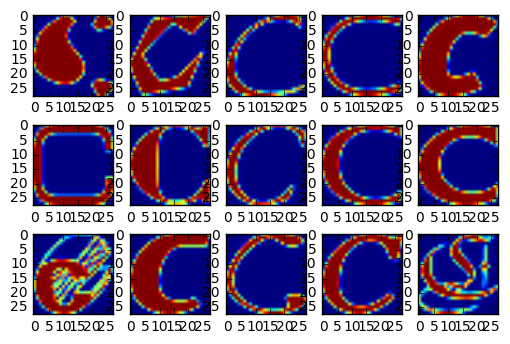

In [26]:
def load_dataset_one_char(file_name):
    if (os.path.isfile(file_name) != True):
        print("Invalid file name:", file_name)
        return

    f = open(file_name, 'rb')
    dataset = pickle.load(f)
    f.close()
    return dataset

data_set = load_dataset_one_char("notMNIST_large/C.pickle")
print('data_set shape is:', data_set.shape)
n = data_set.shape[0]
plt.figure(1)

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(data_set[i+100])
print('Done display of rescaled image')

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [27]:
# Check training data and verification data are balenced in terms of number of samples
import glob
def getNumSamples(afilter):
    try:
        dirlist = glob.glob(afilter)
    except Exception as e:
        print('Unable to list dir', afilter, ':', e)
        return
    folder = afilter.split('/')[0]
    sn=[]
    for fn in dirlist:
        f = open(fn, 'rb')
        dataset = pickle.load(f)
        f.close()
        sn.append(dataset.shape[0])
    return sn

samples = getNumSamples("notMNIST_large/*.pickle")
veries =  getNumSamples("notMNIST_small/*.pickle")
print("Samples:", samples)
print("\tSize=", len(samples), "\tMean=", np.mean(samples), "\tdeviation=", np.std(samples))
print("Verifications:", veries)
print("\tSize=", len(veries), "\tMean=", np.mean(veries), "\tdeviation=", np.std(veries))

Samples: [52911, 52912, 52912, 52912, 52912, 52911, 52911, 52912, 52909, 52912]
	Size= 10 	Mean= 52911.4 	deviation= 0.916515138991
Verifications: [1873, 1872, 1872, 1873, 1873, 1873, 1872, 1872, 1872, 1872]
	Size= 10 	Mean= 1872.4 	deviation= 0.489897948557


[Leon] This section of code generates traning set, validation set, and test set. Each set is represented by two Numpy arrays, one of which contains letter images and the other one contains labels (value 0~9 which represents a letter/class).

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for __hyperparameter__ tuning.

In [28]:
# make Numpy array of square images and Numpy array of integers. Both arrays are returned.
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

# Create training set and validation set and their corresponding labels. All four arrays are returned by this function.
# training set and validation set of one class/letter are read from the same class letter file.
# Training set letters of one class is tsize_per_class = train_size // num_classes. Simillarly for validation set.
# Letters in a class are randomized and then set to training set and validation set.
def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation or training set
        np.random.shuffle(letter_set)
        # If validation set is needed, take vsize_per_class letters from this class and put the letters to validation arrays
        if valid_dataset is not None:  
          valid_letter = letter_set[:vsize_per_class, :, :]  # Take vsize_per_class letters
          valid_dataset[start_v:end_v, :, :] = valid_letter  # Put letters of this class to validation set.
          valid_labels[start_v:end_v] = label                # Set label also for validation set
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :] # Take tsize_per_class letters
        train_dataset[start_t:end_t, :, :] = train_letter      # Put letters of this class to training set
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 400000
valid_size = 15000
test_size = 15000

# Create training set and validation set.
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)

# Create test set. Test set created this way may have the same letters as in training set and validation set.
# This is not good since this test set is NOT indepedant of the training set and validation set.
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (400000, 28, 28) (400000,)
Validation: (15000, 28, 28) (15000,)
Testing: (15000, 28, 28) (15000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

[Leon] This code section shuffle all three sets to have letters of different classes mingled. Without this shuffle, letters of the same class stay together in a set. IS this really necessay? I think the learning algorithm doesn't care sample order.

In [29]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

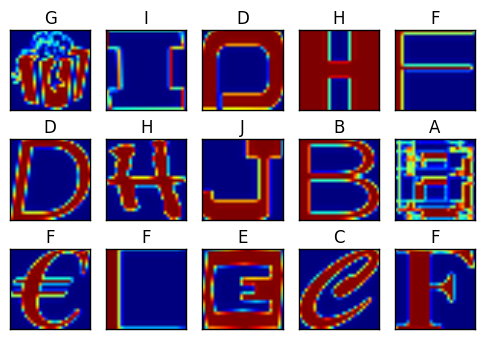

In [30]:
# The code below is more OO. Axes class is returned by plt.subplot().
for i in range(15):
    ax=plt.subplot(3, 5, i+1)
    #ax.format_coord = lambda x, y: ''
    plt.imshow(train_dataset[i+200])
    ax.set_title(chr(train_labels[i+200]+65))
    ax.set_xticks([])
    ax.set_yticks([])

Finally, let's save the data for later reuse:

In [31]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [32]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1350200512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [7]:
import hashlib
import time
from six.moves import cPickle as pickle 
import numpy as np

pickle_file = 'notMNIST.pickle'
start = time.clock()

try:
  f = open(pickle_file, 'br')
  set_dict = pickle.load(f)
  f.close()
except Exception as e:
  print('Unable to read data from', pickle_file, ':', e)
  raise

end = time.clock()
print("===>>> Pickle file reading time is:", end-start)
start = end

train_dataset = set_dict['train_dataset']
train_labels = set_dict['train_labels']
valid_dataset = set_dict['valid_dataset']
valid_labels = set_dict['valid_labels']
test_dataset = set_dict['test_dataset']
test_labels = set_dict['test_labels']

print(type(train_dataset))
print(train_dataset.shape)


# Generate hash list for fast operation. 
# MD5 hash value is 128 bit (16 bytes) which is much smaller than picture size.
train_hash_list=[hashlib.md5(image1.data).digest() for image1 in train_dataset]
valid_hash_list=[hashlib.md5(image1.data).digest() for image1 in valid_dataset]
test_hash_list=[hashlib.md5(image1.data).digest() for image1 in test_dataset]

end = time.clock()
print("===>>> Hash time total is:", end-start)
start = end

# Save number of samples in each dataset
train_samples = len(train_hash_list)
valid_samples = len(valid_hash_list)
test_samples = len(test_hash_list)

# Create set which doesn't contain duplicate samples
train_set = set(train_hash_list) 
valid_set = set(valid_hash_list)
test_set = set(test_hash_list)

print('train_dataset duplicate samples (out of %d):' % train_samples, train_samples-len(train_set))
print('valid_dataset duplicate samples (out of %d):' % valid_samples, valid_samples-len(valid_set))
print('test_dataset duplicate samples (out of %d):' % test_samples, test_samples-len(test_set))

end = time.clock()
print("===>>> List to set conversion time total is:", end-start)
start = end

valid_train_dup = train_set.intersection(valid_set)
print("Validation (%d) and traing (%d) duplicate samples:" % (valid_samples, train_samples), len(valid_train_dup))
end = time.clock()
print("===>>> Validation and traing dup calculation time is:", end-start)
start = end

test_train_dup = train_set.intersection(test_set)
print("Test (%d) and traing (%d) duplicate samples:" % (test_samples, train_samples), len(test_train_dup))
end = time.clock()
print("===>>> Test and traing dup calculation time is:", end-start)


===>>> Pickle file reading time is: 0.433103
<class 'numpy.ndarray'>
(400000, 28, 28)
===>>> Hash time total is: 2.2841689999999994
train_dataset duplicate samples (out of 400000): 41678
valid_dataset duplicate samples (out of 15000): 242
test_dataset duplicate samples (out of 15000): 358
===>>> List to set conversion time total is: 0.06605300000000014
Validation (15000) and traing (400000) duplicate samples: 2459
===>>> Validation and traing dup calculation time is: 0.0016920000000002489
Test (15000) and traing (400000) duplicate samples: 2997
===>>> Test and traing dup calculation time is: 0.00167899999999932


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [14]:
from sklearn.linear_model import LogisticRegression

# Use LogisticRegression class of linear_mode module in sklearn package
# This class requires training dataset and test dataset only. 
# So we are going to use validation dataset in the above Problem as test dataset as validation dataset has
# a little bit less duplicate samples with training data set.

# Specify number of samples used for training and testing
train_num = 100000
test_num =5000

start = time.clock()
# Get data for training and testing
train_x_set = np.reshape(train_dataset[0:train_num], (train_num, 28*28))
train_y_set = train_labels[0:train_num]
test_x_set = np.reshape(valid_dataset[0:test_num], (test_num, 28*28))
test_y_set = valid_labels[0:test_num]

classifier = LogisticRegression()
classifier.fit(train_x_set, train_y_set)

end = time.clock()
print("===>>> Training time is %f seconds" % (end-start))
start = end

mean_accuracy = classifier.score(test_x_set, test_y_set)
print('Prediction mean accuracy is', mean_accuracy)

end = time.clock()
print("===>>> Test time is %f seconds" % (end-start))


===>>> Training time is 633.125491 seconds
Prediction mean accuracy is 0.8206
===>>> Test time is 0.021217 seconds
